# German Used Cars Analysis

## Importing Libraries

In [163]:
import pandas as pd
import numpy as np
from ydata_profiling import ProfileReport
import seaborn as sns
import matplotlib.pyplot as plt

## Loading Dataset

In [164]:
df_org = pd.read_csv('data.csv')
df = df_org.copy()
df = df.iloc[:, 1:]
df.head()

,brand,model,color,registration_date,year,price_in_euro,power_kw,power_ps,transmission_type,fuel_type,fuel_consumption_l_100km,fuel_consumption_g_km,mileage_in_km,offer_description
0,alfa-romeo,Alfa Romeo GTV,red,10/1995,1995,1300,148,201,Manual,Petrol,"10,9 l/100 km",260 g/km,160500.0,2.0 V6 TB
1,alfa-romeo,Alfa Romeo 164,black,02/1995,1995,24900,191,260,Manual,Petrol,NaN,- (g/km),190000.0,"Q4 Allrad, 3.2L GTA"
2,alfa-romeo,Alfa Romeo Spider,black,02/1995,1995,5900,110,150,Unknown,Petrol,NaN,- (g/km),129000.0,ALFA ROME 916
3,alfa-romeo,Alfa Romeo Spider,black,07/1995,1995,4900,110,150,Manual,Petrol,"9,5 l/100 km",225 g/km,189500.0,2.0 16V Twin Spark L
4,alfa-romeo,Alfa Romeo 164,red,11/1996,1996,17950,132,179,Manual,Petrol,"7,2 l/100 km",- (g/km),96127.0,"3.0i Super V6, absoluter Topzustand !"


## 1) Data Understanding

### Export Report File using ydata_profiling package

In [165]:
# profile = ProfileReport(df, title="Profiling Report")
# profile.to_file("used_car_report.html")

### Data Preparing

In [166]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251079 entries, 0 to 251078
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   brand                     251079 non-null  object 
 1   model                     251079 non-null  object 
 2   color                     250913 non-null  object 
 3   registration_date         251075 non-null  object 
 4   year                      251079 non-null  object 
 5   price_in_euro             251079 non-null  object 
 6   power_kw                  250945 non-null  object 
 7   power_ps                  250950 non-null  object 
 8   transmission_type         251079 non-null  object 
 9   fuel_type                 251079 non-null  object 
 10  fuel_consumption_l_100km  224206 non-null  object 
 11  fuel_consumption_g_km     251079 non-null  object 
 12  mileage_in_km             250927 non-null  float64
 13  offer_description         251078 non-null  o

In [167]:
df.isnull().sum()

brand                           0
model                           0
color                         166
registration_date               4
year                            0
price_in_euro                   0
power_kw                      134
power_ps                      129
transmission_type               0
fuel_type                       0
fuel_consumption_l_100km    26873
fuel_consumption_g_km           0
mileage_in_km                 152
offer_description               1
dtype: int64

#### Fixing columns in which contains different types of units

In [168]:
df.fuel_consumption_l_100km = df.fuel_consumption_l_100km.str.replace(',','.')

is_l_km = df.fuel_consumption_l_100km.str.contains('l/100 km', na=False)
is_km = df.fuel_consumption_l_100km.str.contains('km', na=False) & ~df.fuel_consumption_l_100km.str.contains('/', na=False)
is_kwh = df.fuel_consumption_l_100km.str.contains('kWh/100 km', na=False)
is_kg = df.fuel_consumption_l_100km.str.contains('kg/100 km', na=False)

df['fuel_consumption_l_100_km'] = df.loc[is_l_km, 'fuel_consumption_l_100km']
df['fuel_consumption_km'] = df.loc[is_km, 'fuel_consumption_l_100km']
df['fuel_consumption_kWh_100km'] = df.loc[is_kwh, 'fuel_consumption_l_100km']
df['fuel_consumption_kg_100km'] = df.loc[is_kg, 'fuel_consumption_l_100km']

df['fuel_consumption_l_100_km'] = df['fuel_consumption_l_100_km'].str.replace('- (l/100 km)','').str.replace(' l/100 km','').replace('', np.nan)
df['fuel_consumption_km'] = df['fuel_consumption_km'].str.replace(' km (Ort)','')
df['fuel_consumption_kWh_100km'] = df['fuel_consumption_kWh_100km'].str.replace(' kWh/100 km','')
df['fuel_consumption_kg_100km'] = df['fuel_consumption_kg_100km'].str.replace(' kg/100 km','')

#### Drop Columns

In [169]:
df = df.drop(columns=['power_ps', 'fuel_consumption_l_100km', 'fuel_consumption_g_km', 'offer_description'])

#### Removing wrong entry data in columns

In [170]:
year_count = df.year.value_counts()
mask = df.year.map(year_count) < 170
df_cond = df[mask]
df_cond.year.value_counts()

year
Petrol       51
Hybrid       24
Manual       20
Diesel       20
Automatic    14
             ..
39.900 km     1
18.990 km     1
05/2015       1
05/2016       1
CNG           1
Name: count, Length: 62, dtype: int64

In [171]:
mask = df.year.map(year_count) >= 170
df = df[mask]
df.year.value_counts()[-3:]

year
1997    343
1996    227
1995    170
Name: count, dtype: int64

In [172]:
registration_count = df.registration_date.value_counts()
mask = df.registration_date.map(registration_count) < 8
df_cond = df[mask]
df_cond['registration_date'].value_counts()

registration_date
10/1995    3
07/2023    3
11/2023    1
Name: count, dtype: int64

In [173]:
mask = df.registration_date.map(registration_count) >= 8
df = df[mask]
df['registration_date'].value_counts()[-3:]

registration_date
12/1995    9
08/1996    8
09/1995    8
Name: count, dtype: int64

#### Replacing Null Values with appropriate values

In [174]:
df.color = df.color.fillna(df.color.mode()[0])
df.fuel_type = df.fuel_type.replace('Other', 'Unknown')
df['fuel_consumption_l_100_km'] = df['fuel_consumption_l_100_km'].fillna(0)
df['fuel_consumption_km'] = df['fuel_consumption_km'].fillna(0)
df['fuel_consumption_kWh_100km'] = df['fuel_consumption_kWh_100km'].fillna(0)
df['fuel_consumption_kg_100km'] = df['fuel_consumption_kg_100km'].fillna(0)
df.mileage_in_km = df.mileage_in_km.fillna(df.mileage_in_km.mean())

In [175]:
df = df.dropna(subset=['registration_date', 'power_kw'])

#### Converting columns to appropriate Data Types

In [176]:
df.year = df.year.astype('int')
df.price_in_euro = df.price_in_euro.astype('int')
df.power_kw = df.power_kw.astype('int')
df['fuel_consumption_l_100_km'] = df['fuel_consumption_l_100_km'].astype('float')
df['fuel_consumption_km'] = df['fuel_consumption_km'].astype('float')
df['fuel_consumption_kWh_100km'] = df['fuel_consumption_kWh_100km'].astype('float')
df['fuel_consumption_kg_100km'] = df['fuel_consumption_kg_100km'].astype('float')

In [177]:
clean_df = df
clean_df.to_csv('clean_used_cars_dataset.csv', index=False)

## 2) Data Analyzing & Visualization

### 1) Univariate Analysis

##### Category Columns

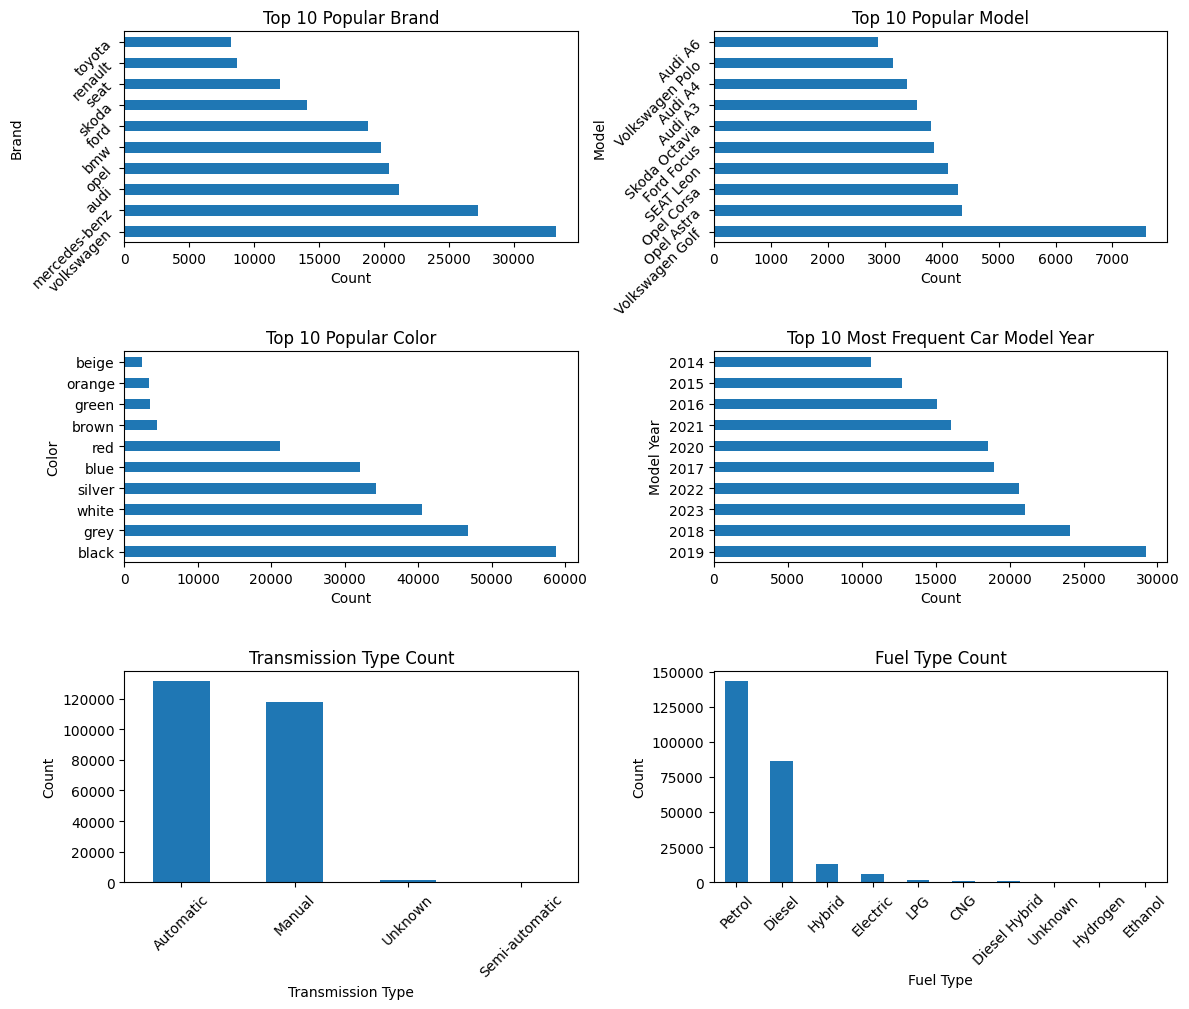

In [178]:
fig, axes = plt.subplots(3,2, figsize=(12,12))

brand_count = clean_df.brand.value_counts()
brand_count[:10].plot(kind='barh', ax=axes[0,0], title='Top 10 Popular Brand', xlabel='Count', ylabel='Brand', rot=45)

model_count = clean_df.model.value_counts()
model_count[:10].plot(kind='barh', ax=axes[0,1], title='Top 10 Popular Model', xlabel='Count', ylabel='Model', rot=45)

color_count = clean_df.color.value_counts()
color_count[:10].plot(kind='barh', ax=axes[1,0], title='Top 10 Popular Color', xlabel='Count', ylabel='Color')

year_count = clean_df.year.value_counts()
year_count[:10].plot(kind='barh', ax=axes[1,1], title='Top 10 Most Frequent Car Model Year', xlabel='Count', ylabel='Model Year')

transmission_type_count = clean_df.transmission_type.value_counts()
transmission_type_count[:10].plot(kind='bar', ax=axes[2,0], title='Transmission Type Count', xlabel='Transmission Type', ylabel='Count', rot=45)

fuel_type_count = clean_df.fuel_type.value_counts()
fuel_type_count[:10].plot(kind='bar', ax=axes[2,1], title='Fuel Type Count', xlabel='Fuel Type', ylabel='Count', rot=45)

plt.tight_layout(rect=[0, 0.1, 1, 0.95])

##### Numerical Columns

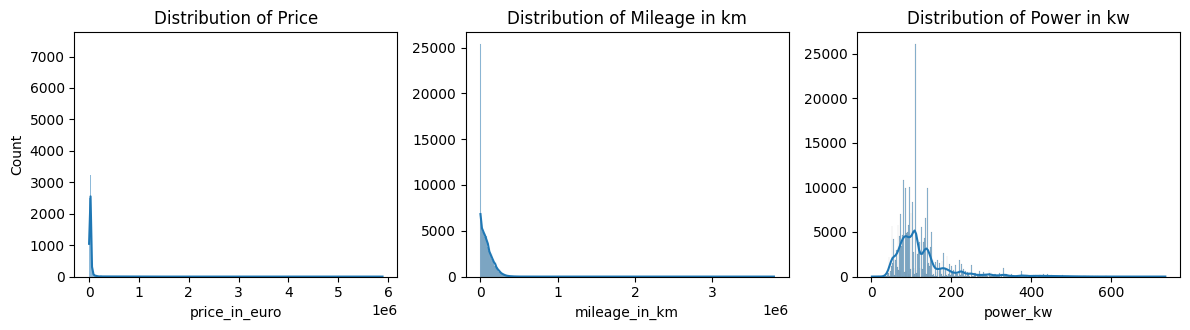

In [179]:
fig, axes = plt.subplots(1,3, figsize=(12,4))

sns.histplot(clean_df, x='price_in_euro', kde=True, ax=axes[0])
axes[0].set_title('Distribution of Price')

sns.histplot(clean_df, x='mileage_in_km', kde=True, ax=axes[1])
axes[1].set_title('Distribution of Mileage in km')
axes[1].set_ylabel('')

sns.histplot(clean_df, x='power_kw', kde=True, ax=axes[2])
axes[2].set_title('Distribution of Power in kw')
axes[2].set_ylabel('')

plt.tight_layout(rect=[0, 0.1, 1, 0.95])
plt.show()

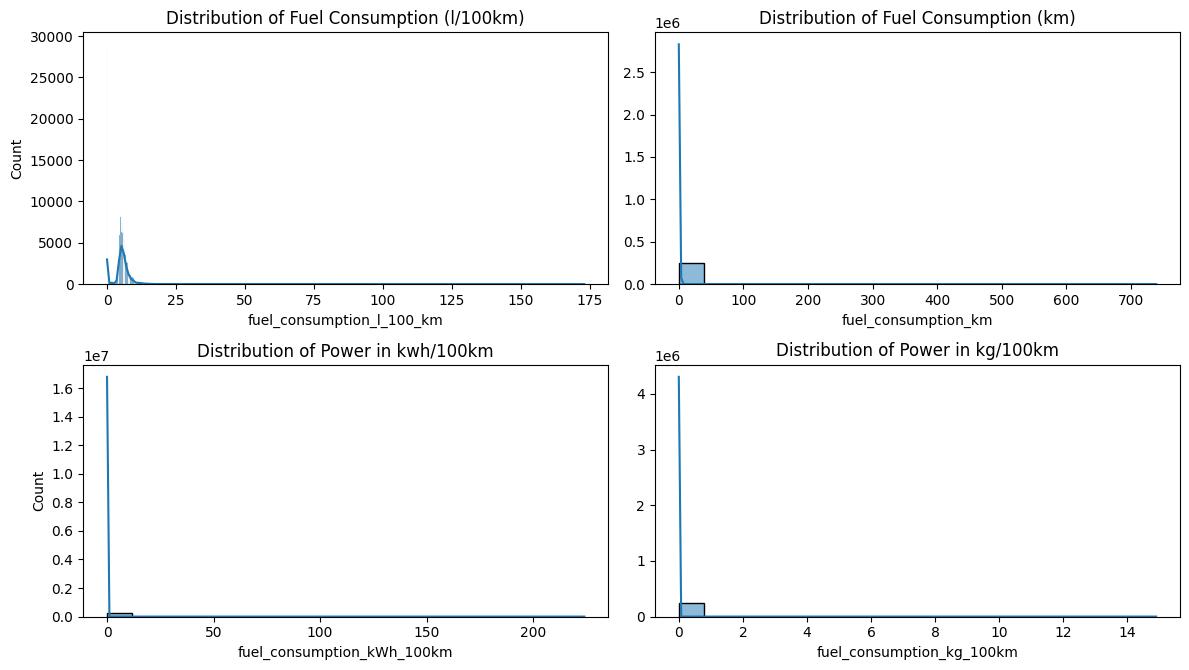

In [180]:
fig, axes = plt.subplots(2,2, figsize=(12,8))

sns.histplot(clean_df, x='fuel_consumption_l_100_km', kde=True, ax=axes[0,0])
axes[0,0].set_title('Distribution of Fuel Consumption (l/100km)')

sns.histplot(clean_df, x='fuel_consumption_km', kde=True, ax=axes[0,1])
axes[0,1].set_title('Distribution of Fuel Consumption (km)')
axes[0,1].set_ylabel('')

sns.histplot(clean_df, x='fuel_consumption_kWh_100km', kde=True, ax=axes[1,0])
axes[1,0].set_title('Distribution of Power in kwh/100km')

sns.histplot(clean_df, x='fuel_consumption_kg_100km', kde=True, ax=axes[1,1])
axes[1,1].set_title('Distribution of Power in kg/100km')
axes[1,1].set_ylabel('')

plt.tight_layout(rect=[0, 0.1, 1, 0.95])
plt.show()

### 2) Bivarient Analysis

In [181]:
clean_df.head()

,brand,model,color,registration_date,year,price_in_euro,power_kw,transmission_type,fuel_type,mileage_in_km,fuel_consumption_l_100_km,fuel_consumption_km,fuel_consumption_kWh_100km,fuel_consumption_kg_100km
1,alfa-romeo,Alfa Romeo 164,black,02/1995,1995,24900,191,Manual,Petrol,190000.0,0.0,0.0,0.0,0.0
2,alfa-romeo,Alfa Romeo Spider,black,02/1995,1995,5900,110,Unknown,Petrol,129000.0,0.0,0.0,0.0,0.0
3,alfa-romeo,Alfa Romeo Spider,black,07/1995,1995,4900,110,Manual,Petrol,189500.0,9.5,0.0,0.0,0.0
4,alfa-romeo,Alfa Romeo 164,red,11/1996,1996,17950,132,Manual,Petrol,96127.0,7.2,0.0,0.0,0.0
5,alfa-romeo,Alfa Romeo Spider,red,04/1996,1996,7900,110,Manual,Petrol,47307.0,9.5,0.0,0.0,0.0


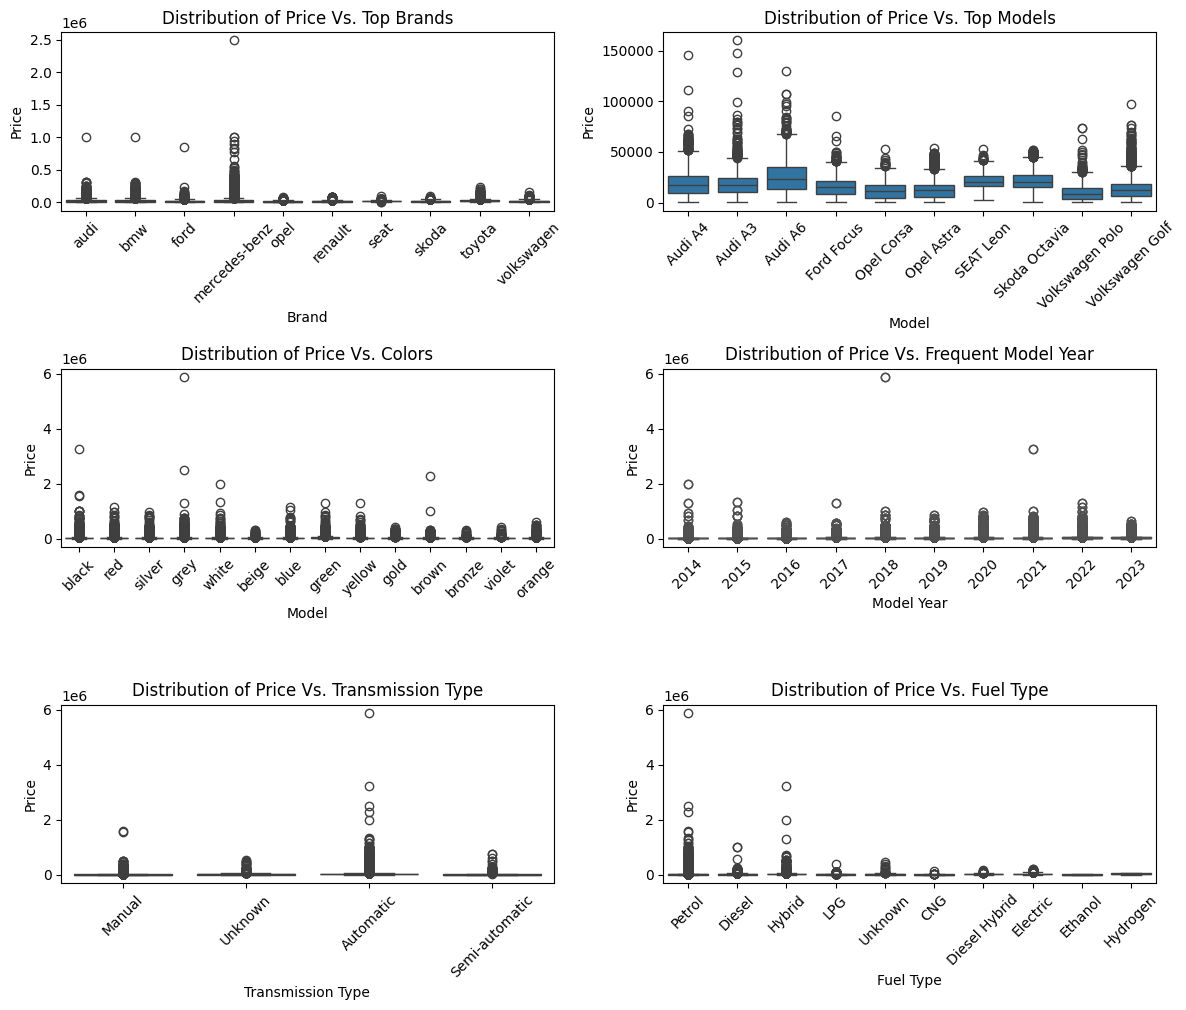

In [182]:
fig, axes = plt.subplots(3,2, figsize=(12,12))

top_brands = clean_df.brand.value_counts()[:10].index
df_filtered = clean_df[clean_df['brand'].isin(top_brands)]
sns.boxplot(df_filtered, x='brand', y='price_in_euro', ax=axes[0,0])
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].set_xlabel('Brand')
axes[0,0].set_ylabel('Price')
axes[0,0].set_title('Distribution of Price Vs. Top Brands')

top_models = clean_df.model.value_counts()[:10].index
df_filtered = clean_df[clean_df['model'].isin(top_models)]
sns.boxplot(df_filtered, x='model', y='price_in_euro', ax=axes[0,1])
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].set_xlabel('Model')
axes[0,1].set_ylabel('Price')
axes[0,1].set_title('Distribution of Price Vs. Top Models')

colors = clean_df.color.value_counts().index
df_filtered = clean_df[clean_df['color'].isin(colors)]
sns.boxplot(df_filtered, x='color', y='price_in_euro', ax=axes[1,0])
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].set_xlabel('Model')
axes[1,0].set_ylabel('Price')
axes[1,0].set_title('Distribution of Price Vs. Colors')

years = clean_df.year.value_counts()[:10].index
df_filtered = clean_df[clean_df['year'].isin(years)]
sns.boxplot(df_filtered, x='year', y='price_in_euro', ax=axes[1,1])
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].set_xlabel('Model Year')
axes[1,1].set_ylabel('Price')
axes[1,1].set_title('Distribution of Price Vs. Frequent Model Year')

years = clean_df.year.value_counts()[:10].index
df_filtered = clean_df[clean_df['year'].isin(years)]
sns.boxplot(df_filtered, x='year', y='price_in_euro', ax=axes[1,1])
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].set_xlabel('Model Year')
axes[1,1].set_ylabel('Price')
axes[1,1].set_title('Distribution of Price Vs. Frequent Model Year')

transmission_type = clean_df.transmission_type.value_counts().index
df_filtered = clean_df[clean_df['transmission_type'].isin(transmission_type)]
sns.boxplot(df_filtered, x='transmission_type', y='price_in_euro', ax=axes[2,0])
axes[2,0].tick_params(axis='x', rotation=45)
axes[2,0].set_xlabel('Transmission Type')
axes[2,0].set_ylabel('Price')
axes[2,0].set_title('Distribution of Price Vs. Transmission Type')

fuel_type = clean_df.fuel_type.value_counts().index
df_filtered = clean_df[clean_df['fuel_type'].isin(fuel_type)]
sns.boxplot(df_filtered, x='fuel_type', y='price_in_euro', ax=axes[2,1])
axes[2,1].tick_params(axis='x', rotation=45)
axes[2,1].set_xlabel('Fuel Type')
axes[2,1].set_ylabel('Price')
axes[2,1].set_title('Distribution of Price Vs. Fuel Type')

plt.tight_layout(rect=[0, 0.1, 1, 0.95])
plt.show()

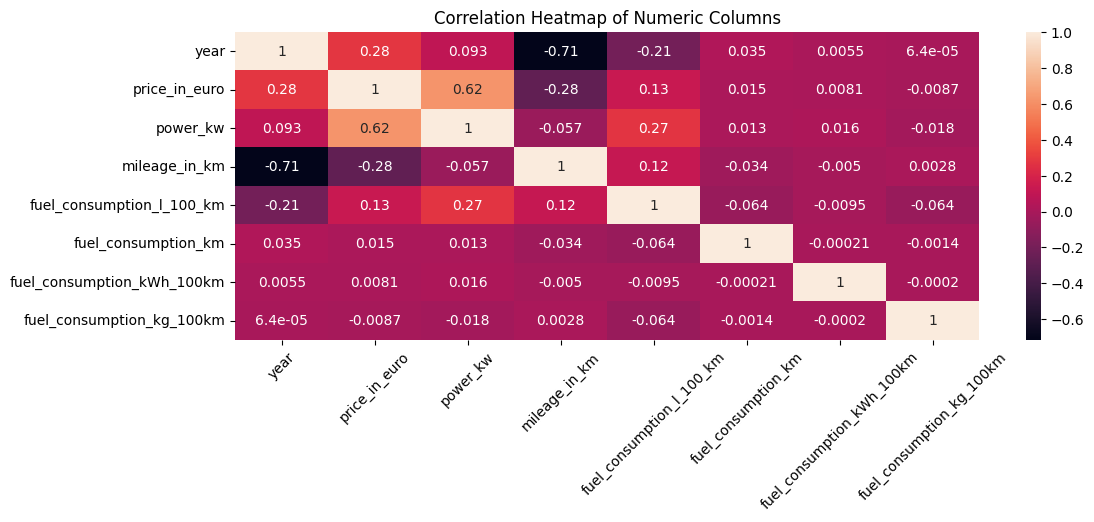

In [187]:
numeric_df = clean_df.select_dtypes('number')

fig, ax = plt.subplots(figsize=(12,4))
sns.heatmap(numeric_df.corr(), annot=True, ax=ax)
plt.tick_params(axis='x', rotation=45)
ax.set_title('Correlation Heatmap of Numeric Columns')
plt.show()

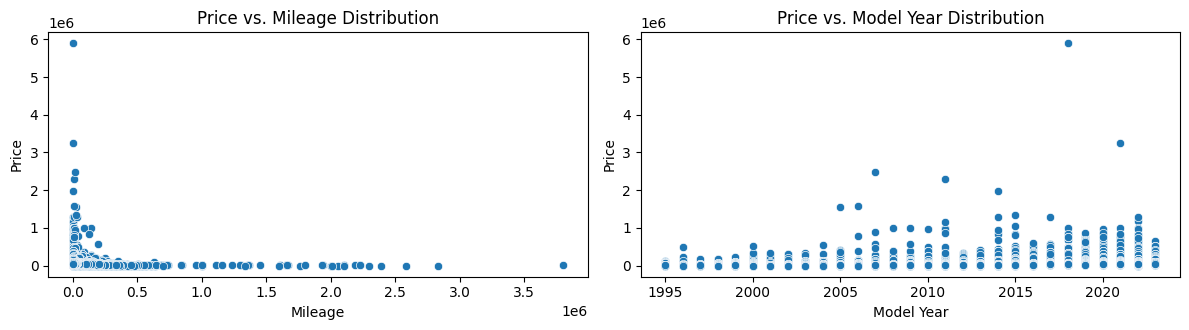

In [200]:
fig, axes = plt.subplots(1,2, figsize=(12, 4))

sns.scatterplot(data=clean_df, x='mileage_in_km', y='price_in_euro', ax=axes[0])
axes[0].set_title('Price vs. Mileage Distribution')
axes[0].set_xlabel('Mileage')
axes[0].set_ylabel('Price')

sns.scatterplot(data=clean_df, x='year', y='price_in_euro', ax=axes[1])
axes[1].set_title('Price vs. Model Year Distribution')
axes[1].set_xlabel('Model Year')
axes[1].set_ylabel('Price')

plt.tight_layout(rect=[0, 0.1, 1, 0.95])
plt.show()